Aufgabe 50.

Bonusaufgabe: Führen Sie die Regressionsdiagnostik für ein eigenes Modell auf Basis
Ihres selbst gewählten Datensatzes durch.

### Einstellen

In [234]:
import pandas as pd
from utils import *
from statsmodels.api import OLS, add_constant, qqplot
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder

In [235]:
sns.set(style="whitegrid")
pd.set_option('display.max_columns', 100)
healthy_orange = '#EC6602'
healthy_orange_50 = '#F9B591'
healthy_orange_25 = '#FDDDCB'
siemens_petrol = '#009999'
siemens_petrol_50 = '#87D2D2'
sns.set_palette([healthy_orange, siemens_petrol, healthy_orange_50, healthy_orange_25, siemens_petrol_50])
RANDOM_SEED = 42

### Daten Importieren

In [236]:
df_ = pd.read_pickle('../data/cleaned_data_2.pkl').drop_duplicates()

### Copy Erzeugen

In [237]:
df = df_.copy()
df.head()

,obid,plz,mietekalt,wohnflaeche,etage,zimmeranzahl,schlafzimmer,badezimmer,aufzug,balkon,einbaukueche,foerderung,gaestewc,garten,keller,parkplatz,ausstattung,haustier_erlaubt,heizungsart,kategorie_Wohnung,objektzustand,blid,rent_sqm,is_schlafzimmer_imputed,is_parkplatz_imputed,year,month
81,41534430,22587,918.00,114.700000,1,4.0,1.0,1.0,0,1,1,0,0,0,0,0,Sophisticated,By arrangement,Central heating,Not specified,Completely renovated,Hamburg,8.003488,False,True,2007,5
94,42410574,20251,374.33,48.000000,1,2.0,1.0,1.0,0,1,0,0,0,0,0,0,Not specified,By arrangement,Not specified,Flat,Well-kept,Hamburg,7.798541,False,True,2007,7
127,38404913,22303,565.60,74.000000,4,3.0,1.0,1.0,0,0,1,0,0,0,1,0,Normal,No,Central heating,Flat,Well-kept,Hamburg,7.643243,False,True,2007,6
162,41026870,22765,284.00,40.410000,4,2.0,1.0,1.0,1,1,1,1,0,1,1,0,Normal,No,Central heating,Attic flat,Like new,Hamburg,7.027964,False,True,2007,3
171,36771732,20357,373.00,55.439999,2,2.0,1.0,1.0,0,0,0,0,0,0,0,0,Normal,By arrangement,Self-contained central heating,Flat,Not specified,Hamburg,6.727994,False,True,2007,7


### Prädiktor Datentyp Festlegen

In [238]:
var_types = {
    "obid": "categorical",
    "plz": "categorical",
    "mietekalt": "numerical",
    "wohnflaeche": "numerical",
    "etage": "ordinal",
    "zimmeranzahl": "ordinal",
    "schlafzimmer": "ordinal",
    "badezimmer": "ordinal",
    "aufzug": "binary",
    "balkon": "binary",
    "einbaukueche": "binary",
    "foerderung": "categorical",
    "gaestewc": "binary",
    "garten": "binary",
    "keller": "binary",
    "parkplatz": "binary",
    "ausstattung": "categorical",
    "haustier_erlaubt": "categorical",
    "heizungsart": "categorical",
    "kategorie_Wohnung": "categorical",
    "objektzustand": "categorical",
    "blid": "categorical",
    "rent_sqm": "numerical",
    "year": "ordinal",
    "month": "ordinal",
    'is_schlafzimmer_imputed': 'binary',
    'is_parkplatz_imputed': 'binary'
}

### Ordinale Prädiktoren

In [239]:
ordinal_cols = [col for col, t in var_types.items() if t == "ordinal"]
df[ordinal_cols]

,etage,zimmeranzahl,schlafzimmer,badezimmer,year,month
81,1,4.0,1.0,1.0,2007,5
94,1,2.0,1.0,1.0,2007,7
127,4,3.0,1.0,1.0,2007,6
162,4,2.0,1.0,1.0,2007,3
171,2,2.0,1.0,1.0,2007,7
...,...,...,...,...,...,...
4755927,5,2.0,1.0,1.0,2023,12
4755930,2,2.0,1.0,1.0,2023,12
4755931,4,2.0,1.0,1.0,2023,12
4755936,2,2.0,1.0,1.0,2023,3


In [240]:
ordinal_encoder = OrdinalEncoder()
df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])
df[ordinal_cols]

,etage,zimmeranzahl,schlafzimmer,badezimmer,year,month
81,2.0,39.0,1.0,1.0,0.0,4.0
94,2.0,10.0,1.0,1.0,0.0,6.0
127,5.0,28.0,1.0,1.0,0.0,5.0
162,5.0,10.0,1.0,1.0,0.0,2.0
171,3.0,10.0,1.0,1.0,0.0,6.0
...,...,...,...,...,...,...
4755927,6.0,10.0,1.0,1.0,16.0,11.0
4755930,3.0,10.0,1.0,1.0,16.0,11.0
4755931,5.0,10.0,1.0,1.0,16.0,11.0
4755936,3.0,10.0,1.0,1.0,16.0,2.0


### Binäre Prädiktoren

In [241]:
binary_cols = [col for col, t in var_types.items() if t == "binary"]
df[binary_cols] = df[binary_cols].astype(int)
df[binary_cols]

,aufzug,balkon,einbaukueche,gaestewc,garten,keller,parkplatz,is_schlafzimmer_imputed,is_parkplatz_imputed
81,0,1,1,0,0,0,0,0,1
94,0,1,0,0,0,0,0,0,1
127,0,0,1,0,0,1,0,0,1
162,1,1,1,0,1,1,0,0,1
171,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
4755927,1,1,1,0,0,0,0,0,1
4755930,0,1,0,0,0,0,0,0,1
4755931,1,1,1,1,0,0,0,0,1
4755936,0,1,0,0,0,0,0,0,1


### X, y Festlegen

In [242]:
X = df.drop(columns=['obid', 'mietekalt', 'plz', 'rent_sqm'])
y = df['mietekalt']

### Kategoriale Prädiktoren

In [243]:
categorical_cols = [col for col, t in var_types.items() if t == "categorical" and col in X.columns]
df[categorical_cols]

,foerderung,ausstattung,haustier_erlaubt,heizungsart,kategorie_Wohnung,objektzustand,blid
81,0,Sophisticated,By arrangement,Central heating,Not specified,Completely renovated,Hamburg
94,0,Not specified,By arrangement,Not specified,Flat,Well-kept,Hamburg
127,0,Normal,No,Central heating,Flat,Well-kept,Hamburg
162,1,Normal,No,Central heating,Attic flat,Like new,Hamburg
171,0,Normal,By arrangement,Self-contained central heating,Flat,Not specified,Hamburg
...,...,...,...,...,...,...,...
4755927,0,Not specified,By arrangement,Floor heating,Attic flat,Well-kept,The Free State of Saxony
4755930,0,Not specified,By arrangement,Central heating,Not specified,Not specified,The Free State of Saxony
4755931,0,Normal,By arrangement,Not specified,Flat,Well-kept,The Free State of Saxony
4755936,0,Not specified,By arrangement,Central heating,Not specified,Not specified,The Free State of Saxony


### Dummy Variable Erzeugen

In [244]:
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True, dtype=int)
X.head()

,wohnflaeche,etage,zimmeranzahl,schlafzimmer,badezimmer,aufzug,balkon,einbaukueche,gaestewc,garten,keller,parkplatz,is_schlafzimmer_imputed,is_parkplatz_imputed,year,month,foerderung_1,ausstattung_Normal,ausstattung_Not specified,ausstattung_Simple,ausstattung_Sophisticated,haustier_erlaubt_No,haustier_erlaubt_Yes,heizungsart_Cogeneration/combined heat and power plant,heizungsart_District heating,heizungsart_Electric heating,heizungsart_Floor heating,heizungsart_Gas heating,heizungsart_Heating by stove,heizungsart_Night storage heaters,heizungsart_Not specified,heizungsart_Oil heating,heizungsart_Self-contained central heating,heizungsart_Solar heating,heizungsart_Thermal heat pump,heizungsart_Wood pellet heating,kategorie_Wohnung_Attic flat,kategorie_Wohnung_Flat,kategorie_Wohnung_Flat with terrace,kategorie_Wohnung_Maisonette,kategorie_Wohnung_Not specified,kategorie_Wohnung_Other,kategorie_Wohnung_Penthouse,kategorie_Wohnung_Raised ground florr flat,kategorie_Wohnung_Souterrain,objektzustand_Completely renovated,objektzustand_Dilapidated,objektzustand_First occupancy,objektzustand_First occupancy after reconstruction,objektzustand_Like new,objektzustand_Modernised,objektzustand_Needs renovation,objektzustand_Not specified,objektzustand_Reconstructed,objektzustand_Well-kept,blid_Bavaria,blid_Berlin,blid_Brandenburg,blid_Free Hanseatic City of Bremen,blid_Hamburg,blid_Hesse,blid_Lower Saxony,blid_Mecklenburg-Western Pommerania,blid_North Rhine-Westphalia,blid_Rhineland-Palatine,blid_Saarland,blid_Saxony-Anhalt,blid_Schleswig Holstein,blid_The Free State of Saxony,blid_The Free State of Thuringia
81,114.700000,2.0,39.0,1.0,1.0,0,1,1,0,0,0,0,0,1,0.0,4.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
94,48.000000,2.0,10.0,1.0,1.0,0,1,0,0,0,0,0,0,1,0.0,6.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
127,74.000000,5.0,28.0,1.0,1.0,0,0,1,0,0,1,0,0,1,0.0,5.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
162,40.410000,5.0,10.0,1.0,1.0,1,1,1,0,1,1,0,0,1,0.0,2.0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
171,55.439999,3.0,10.0,1.0,1.0,0,0,0,0,0,0,0,0,1,0.0,6.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### Train Test Split

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modell Anpassen

In [246]:
model = OLS(y_train, add_constant(X_train)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              mietekalt   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                 8.540e+04
Date:                Sat, 07 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:43:34   Log-Likelihood:            -1.1011e+07
No. Observations:             1653644   AIC:                         2.202e+07
Df Residuals:                 1653573   BIC:                         2.202e+07
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

### Normalität Überprüfen

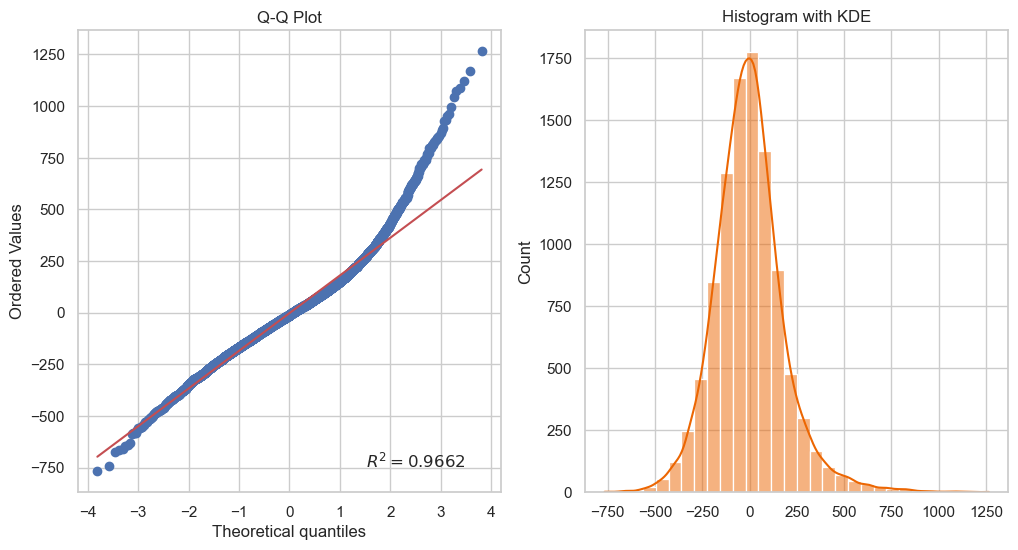

Shapiro-Wilk normality test: p-value = 0.0000
D'Agostino's K^2 normality test: p-value = 0.0000
Kolmogorov-Smirnov normality test: p-value = 0.0000
Anderson-Darling normality test: statistic = 57.0081, critical value = 0.7870


/Users/omer/miniforge3/envs/statistics/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


In [247]:
check_normality(model.resid.sample(10000))

### Homoskedastizität Überprüfen

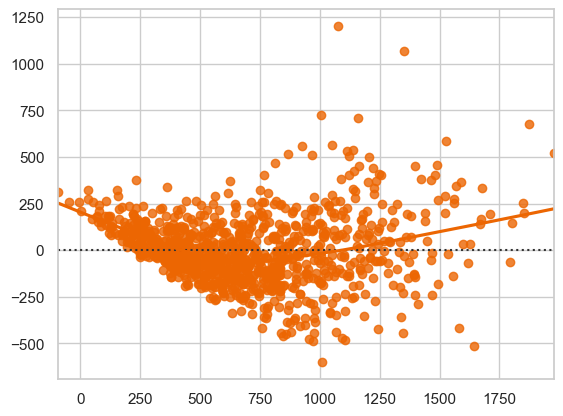

In [248]:
indices = np.random.choice(model.resid.index, size=1000, replace=False)
y_sample = model.resid.loc[indices]
x_sample = model.fittedvalues.loc[indices]
sns.residplot(x=x_sample, y=y_sample, lowess=True);

### Modell Testen

In [249]:
y_pred = model.predict(add_constant(X_test))
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 35620.64
Root Mean Squared Error: 188.73
R-squared: 0.78


### Cramer`s V

In [250]:
cramers_v = cramers_v_matrix(df.sample(10000))
cramers_v

,ausstattung,haustier_erlaubt,heizungsart,kategorie_Wohnung,objektzustand,blid,obid,plz,mietekalt,wohnflaeche,etage,zimmeranzahl,schlafzimmer,badezimmer,aufzug,balkon,einbaukueche,foerderung,gaestewc,garten,keller,parkplatz,rent_sqm,is_schlafzimmer_imputed,is_parkplatz_imputed,year,month
ausstattung,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
haustier_erlaubt,0.082874,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
heizungsart,0.166403,0.060897,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kategorie_Wohnung,0.147272,0.057873,0.071224,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
objektzustand,0.313129,0.091632,0.155795,0.087279,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
blid,0.087153,0.176971,0.113617,0.080834,0.140071,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
obid,0.062821,0.064140,0.213677,0.104234,0.106510,0.085787,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
plz,0.076945,0.149944,0.134298,0.111379,0.201782,0.900326,0.065524,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mietekalt,0.248506,0.078511,0.167361,0.140716,0.222666,0.256163,0.161967,0.216205,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wohnflaeche,0.149789,0.049189,0.067821,0.136891,0.105340,0.048631,0.046298,0.027812,0.376941,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


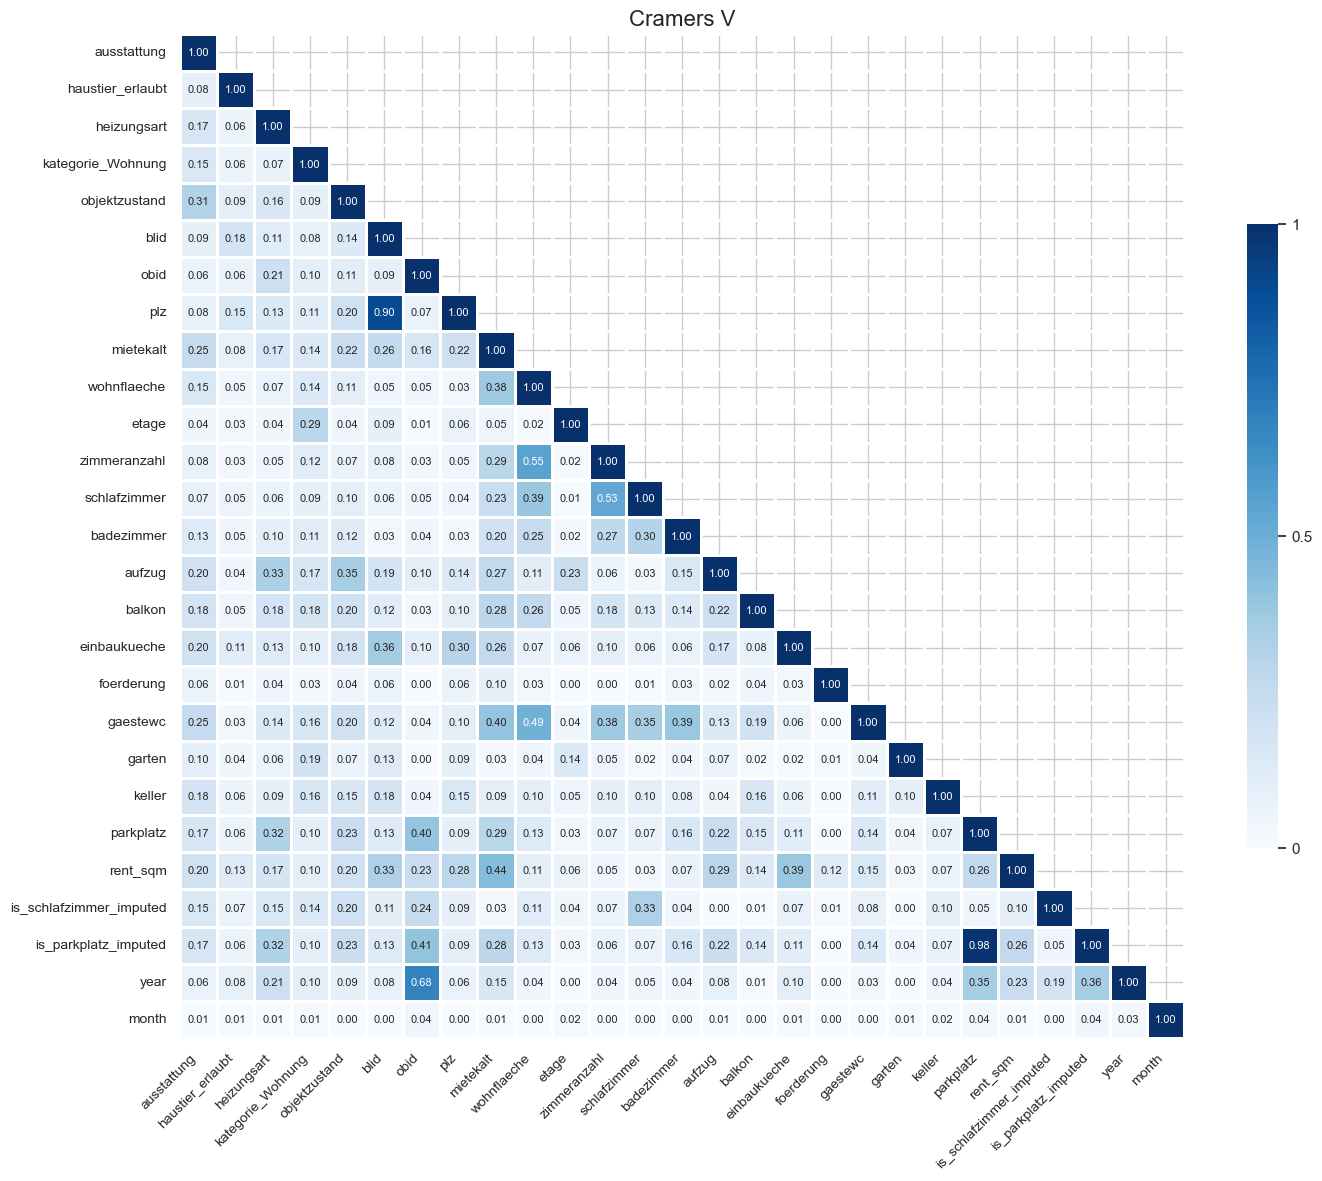

In [251]:
cat_corr_heatmap(cramers_v);

### Pearson

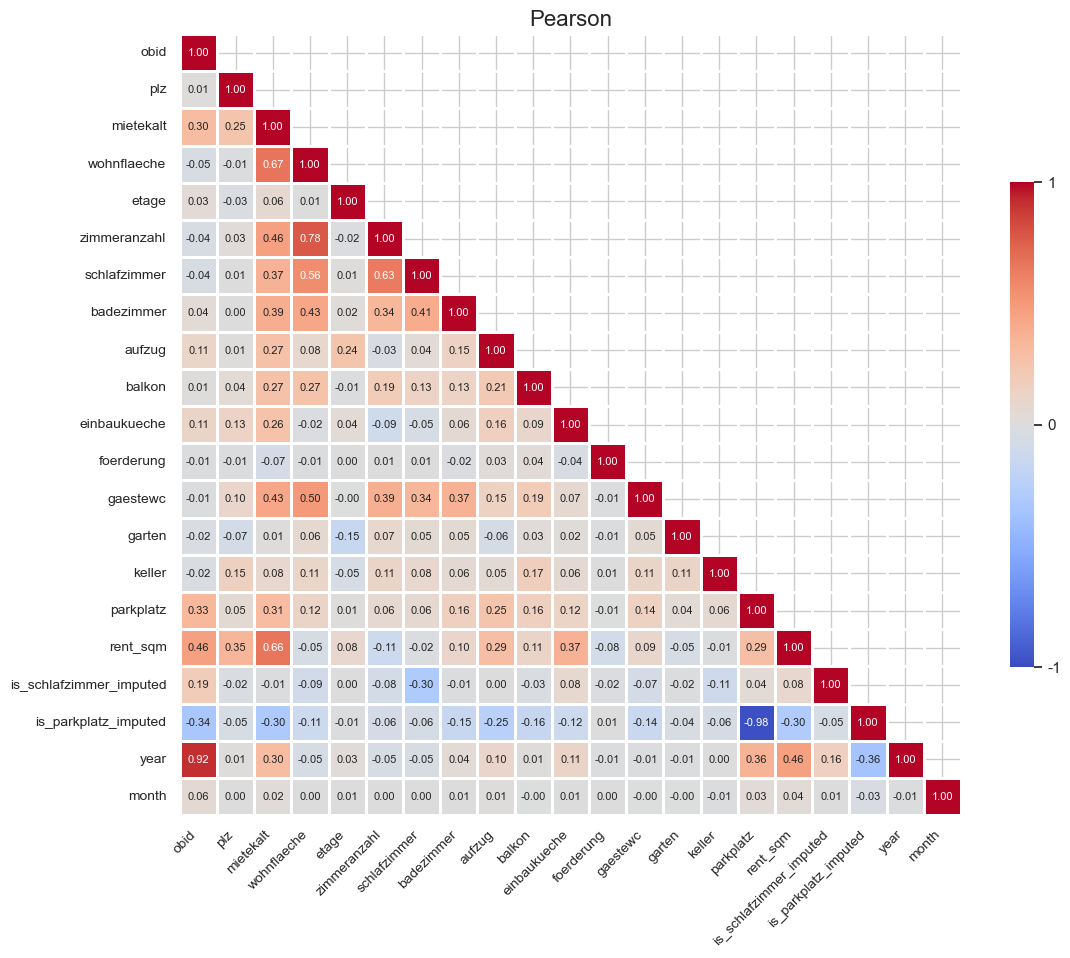

In [252]:
num_corr_heatmap(df.corr(numeric_only=True));

In [253]:
print("done")

done


### Signifikanztest für `blid`

In [254]:
model.compare_f_test(OLS(y_train, add_constant(
    X_train.drop(
        columns=['blid_Bavaria', 'blid_Berlin', 'blid_Brandenburg',
                'blid_Free Hanseatic City of Bremen', 'blid_Hamburg', 'blid_Hesse',
                'blid_Lower Saxony', 'blid_Mecklenburg-Western Pommerania',
                'blid_North Rhine-Westphalia', 'blid_Rhineland-Palatine',
                'blid_Saarland', 'blid_Saxony-Anhalt', 'blid_Schleswig Holstein',
                'blid_The Free State of Saxony', 'blid_The Free State of Thuringia']))).fit())[1]

np.float64(0.0)

### Cross Validation

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []
rmse_scores = []
r2_scores = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = root_mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
cv_mse = np.mean(mse_scores)
cv_rmse = np.mean(rmse_scores)
cv_r2 = np.mean(r2_scores)

print(f"Durchschnittlicher MSE: {cv_mse:.2f}")
print(f"Durchschnittlicher RMSE: {cv_rmse:.2f}")
print(f"Durchschnittlicher R2: {cv_r2:.4f}")

Durchschnittlicher MSE: 35575.04
Durchschnittlicher RMSE: 188.61
Durchschnittlicher R²: 0.7832


### Bootstrapping

In [ ]:
n_iterations = 100
mse_scores = []
rmse_scores = []
r2_scores = []

for i in range(n_iterations):
    X_train_bs, y_train_bs = resample(X_train, y_train, random_state=i)
    model = LinearRegression()
    model.fit(X_train_bs, y_train_bs)
    X_bs, y_bs = resample(X_test, y_test, random_state=i)
    y_pred = model.predict(X_bs)
    mse = mean_squared_error(y_bs, y_pred)
    rmse = root_mean_squared_error(y_bs, y_pred)
    r2 = r2_score(y_bs, y_pred)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
print(f"MSE 95%-CI: [{np.percentile(mse_scores, 2.5):.2f}, {np.percentile(mse_scores, 97.5):.2f}]")
print(f"RMSE 95%-CI: [{np.percentile(rmse_scores, 2.5):.2f}, {np.percentile(rmse_scores, 97.5):.2f}]")
print(f"R2 95%-CI: [{np.percentile(r2_scores, 2.5):.4f}, {np.percentile(r2_scores, 97.5):.4f}]")

MSE 95%-CI: [35408.60, 35876.20]
RMSE 95%-CI: [188.17, 189.41]
R² 95%-CI: [0.7816, 0.7839]


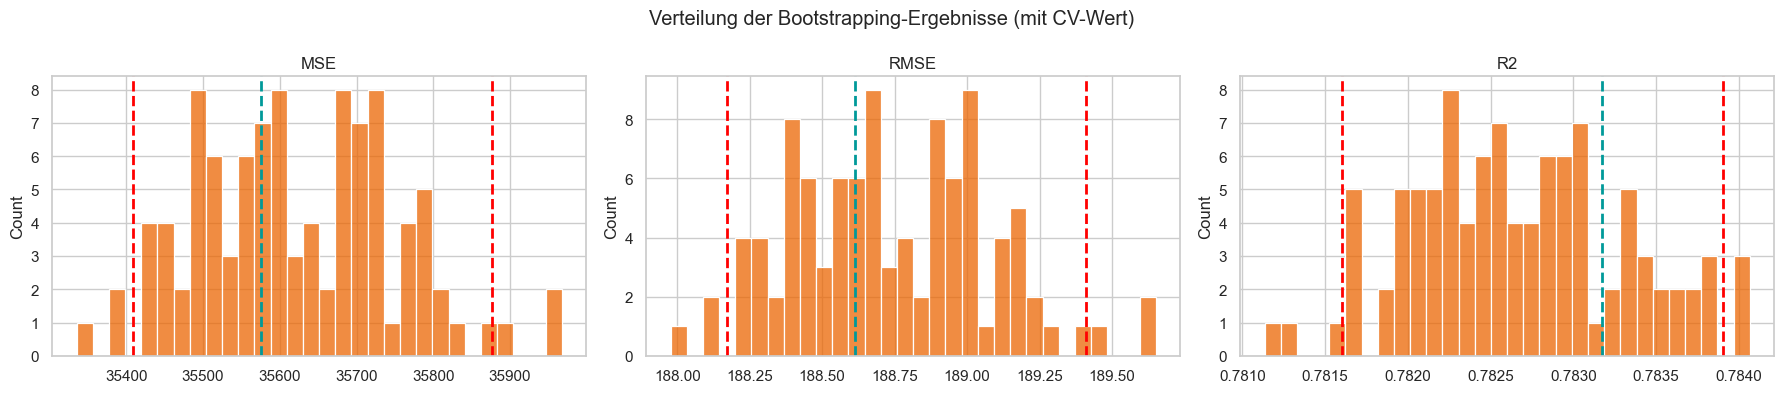

In [282]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(mse_scores, bins=30, ax=axes[0])
axes[0].axvline(cv_mse, color=siemens_petrol, linestyle='--', linewidth=2)
axes[0].axvline(np.percentile(mse_scores, 2.5), color='red', linestyle='--', linewidth=2)
axes[0].axvline(np.percentile(mse_scores, 97.5), color='red', linestyle='--', linewidth=2)
axes[0].set_title('MSE')

sns.histplot(rmse_scores, bins=30, ax=axes[1])
axes[1].axvline(cv_rmse, color=siemens_petrol, linestyle='--', linewidth=2)
axes[1].axvline(np.percentile(rmse_scores, 2.5), color='red', linestyle='--', linewidth=2)
axes[1].axvline(np.percentile(rmse_scores, 97.5), color='red', linestyle='--', linewidth=2)
axes[1].set_title('RMSE')

sns.histplot(r2_scores, bins=30, ax=axes[2])
axes[2].axvline(cv_r2, color=siemens_petrol, linestyle='--', linewidth=2)
axes[2].axvline(np.percentile(r2_scores, 2.5), color='red', linestyle='--', linewidth=2)
axes[2].axvline(np.percentile(r2_scores, 97.5), color='red', linestyle='--', linewidth=2)
axes[2].set_title('R2')

fig.suptitle('Verteilung der Bootstrapping-Ergebnisse (mit CV-Wert)')
plt.tight_layout()
plt.show()

### VIF

In [199]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_sample = X.sample(5000, random_state=42)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_sample.columns
vif_data["VIF"] = [variance_inflation_factor(X_sample.values, i)
                   for i in range(X.shape[1])]

vif_data.sort_values("VIF", ascending=False).head(10)

/Users/omer/miniforge3/envs/statistics/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,Feature,VIF
13,is_parkplatz_imputed,93.268869
37,kategorie_Wohnung_Flat,29.767757
0,wohnflaeche,28.823248
11,parkplatz,26.892943
54,objektzustand_Well-kept,25.666160
4,badezimmer,23.315207
52,objektzustand_Not specified,14.878657
45,objektzustand_Completely renovated,12.010585
3,schlafzimmer,11.998297
53,objektzustand_Reconstructed,11.905815


### Bewertung

Unser finales lineares Modell erzielte eine gute Leistung mit einem Cross-Validation-R2 von 0.7832. Das zugehörige bootstrapped Konfidenzintervall lag bei [0.7816, 0.7839]. Der RMSE im Cross-Validation-Test betrug 188.61, mit einem Bootstrapped-Konfidenzintervall von [188.17, 189.41].

Obwohl das lineare Modell insgesamt solide ist, ist der RMSE in Bezug auf die Anwendung, die Vorhersage der Kaltmiete, relativ hoch. Dies deutet darauf hin, dass weiteres Verbesserungspotenzial besteht, sei es durch Optimierung des Modells oder durch Einsatz komplexerer Verfahren.